In [1]:
import os, sys
sys.path.append('/data/spark15/python/')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 9)
import seaborn as sb
import numpy as np
import pandas as pd

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import HiveContext
from pyspark.sql.types import *
import pyspark.sql.functions

sc = SparkContext("local", "hospital_compare")
sqlContext = SQLContext(sc)
hc = HiveContext(sc)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
print(hc.tableNames())

[u'effective_care', u'effective_care_scores', u'hospitals', u'measures', u'readmissions', u'survey_responses']


## Introduction

We are asked with the task of analyzing the data sets provided The Center for Medicare and Medicaid Services in their Hospital Compare Download Database. Our goal is to answer the following four questions

1. What hospitals are models of high-quality care? That is, which hospitals have the most consistently high scores for a variety of procedures.
2. What states are models of high-quality care?
3. Which procedures have the greatest variability between hospitals?
4. Are average scores for hospital quality or procedural variability correlated with patient survey responses

In the first few steps of our exercise, we downloaded the following four tables and saved to Hive

- __Hospitals__:        General information for each hospital in the Compare database
- __Measures__:         Current collection dates for all measures on Hospital Compare
- __Readmissions__:     Veterans Health Administration hospital-level data for mortality and readmissions measures
- __Survey_Responses__: Survey results for hospitals in Compare database 
- __Effective Care__:   Hospital-level results on patient experience domain measures for Hospital Value-Based Purchasing


#### We will use this notebook as an initial exploration of the data provided to us to help better formulate our transformations and final tables for our analysis.

### Examining Each Table

In [5]:
hospitals = hc.sql('select * from hospitals').toPandas()
measures = hc.sql('select * from measures').toPandas()
readmissions = hc.sql('select * from readmissions').toPandas()
survey_responses = hc.sql('select * from survey_responses').toPandas()
effective_care = hc.sql('select * from effective_care').toPandas()

In [6]:
hospitals.head().T

,0,1,2,3,4
provider_id,010001,010005,010006,010007,010008
hospital_name,SOUTHEAST ALABAMA MEDICAL CENTER,MARSHALL MEDICAL CENTER SOUTH,ELIZA COFFEE MEMORIAL HOSPITAL,MIZELL MEMORIAL HOSPITAL,CRENSHAW COMMUNITY HOSPITAL
address,1108 ROSS CLARK CIRCLE,2505 U S HIGHWAY 431 NORTH,205 MARENGO STREET,702 N MAIN ST,101 HOSPITAL CIRCLE
city,DOTHAN,BOAZ,FLORENCE,OPP,LUVERNE
state,AL,AL,AL,AL,AL
zip_code,36301,35957,35631,36467,36049
county_name,HOUSTON,MARSHALL,LAUDERDALE,COVINGTON,CRENSHAW
phone_number,3347938701,2565938310,2567688400,3344933541,3343353374
hospital_type,Acute Care Hospitals,Acute Care Hospitals,Acute Care Hospitals,Acute Care Hospitals,Acute Care Hospitals
hospital_ownership,Government - Hospital District or Authority,Government - Hospital District or Authority,Government - Hospital District or Authority,Voluntary non-profit - Private,Proprietary


In [7]:
measures.T

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
measure_name,ACS Participation data,Fibrinolytic Therapy Received Within 30 Minute...,Fibrinolytic Therapy Received Within 30 Minute...,Combined SSI,Combined SSI,Complication Rate Following Elective Primary T...,Communication with Nurses,Communication with Doctors,Responsiveness of Hospital Staff,Pain Management,...,Participation in a Systematic Clinical Databas...,HCAHPS Summary Star Rating,Overall Star Rating,Thrombolytic Therapy,Alcohol Use Screening,Tobacco Use Screening,Tobacco Use Treatment Provided or Offered,Tobacco Use Treatment (during the hospital stay),Venous Thromboembolism Warfarin Therapy Discha...,Hospital Acquired Potentially-Preventable Veno...
measure_id,ACS_REGISTRY,AMI_7a_HVBP_Baseline,AMI_7a_HVBP_Performance,Combined_SSI_Measure_Score,Combined_SSI_Measure_Score_HVBP_Performance,COMP_HIP_KNEE,Composite 1 Q1 to Q3,Composite 2 Q5 to Q7,Composite 3 Q4 & Q11,Composite 4 Q13 & Q14,...,SM_PART_NURSE,Star Rating,Star Rating,STK_4,SUB_1,TOB_1,TOB_2,TOB_2a,VTE_5,VTE_6
measure_start_quarter,4Q2015,1Q2013,1Q2015,1Q2013,1Q2015,2Q2013,1Q2016,1Q2016,1Q2016,1Q2016,...,1Q2015,1Q2016,1Q2016,1Q2016,1Q2015,1Q2015,1Q2015,1Q2015,1Q2016,1Q2016
measure_start_date,10/01/2015,01/01/2013,01/01/2015,01/01/2013,01/01/2015,04/01/2013,01/01/2016,01/01/2016,01/01/2016,01/01/2016,...,01/01/2015,01/01/2016,01/01/2016,01/01/2016,01/01/2015,01/01/2015,01/01/2015,01/01/2015,01/01/2016,01/01/2016
measure_end_quarter,3Q2016,4Q2013,4Q2015,4Q2013,4Q2015,1Q2016,4Q2016,4Q2016,4Q2016,4Q2016,...,4Q2015,4Q2016,4Q2016,4Q2016,4Q2015,4Q2015,4Q2015,4Q2015,4Q2016,4Q2016
measure_end_date,09/30/2016,12/31/2013,12/31/2015,12/31/2013,12/31/2015,03/31/2016,12/31/2016,12/31/2016,12/31/2016,12/31/2016,...,12/31/2015,12/31/2016,12/31/2016,12/31/2016,12/31/2015,12/31/2015,12/31/2015,12/31/2015,12/31/2016,12/31/2016


In [8]:
readmissions.head().T

,0,1,2,3,4
provider_id,01014F,01014F,01014F,01014F,01014F
hospital_name,BIRMINGHAM VA MEDICAL CENTER,BIRMINGHAM VA MEDICAL CENTER,BIRMINGHAM VA MEDICAL CENTER,BIRMINGHAM VA MEDICAL CENTER,BIRMINGHAM VA MEDICAL CENTER
address,700 SOUTH 19TH STREET,700 SOUTH 19TH STREET,700 SOUTH 19TH STREET,700 SOUTH 19TH STREET,700 SOUTH 19TH STREET
city,BIRMINGHAM,BIRMINGHAM,BIRMINGHAM,BIRMINGHAM,BIRMINGHAM
state,AL,AL,AL,AL,AL
zip_code,35233,35233,35233,35233,35233
county_name,JEFFERSON,JEFFERSON,JEFFERSON,JEFFERSON,JEFFERSON
measure_name,Acute Myocardial Infarction (AMI) 30-Day Morta...,Death rate for chronic obstructive pulmonary d...,Heart failure (HF) 30-Day Mortality Rate,Pneumonia (PN) 30-Day Mortality Rate,Acute Myocardial Infarction (AMI) 30-Day Readm...
measure_id,MORT-30-AMI,MORT-30-COPD,MORT-30-HF,MORT-30-PN,READM-30-AMI
vha_national_rate,9.21,5.99,7.72,8.64,15.57


In [9]:
effective_care.head().T

,0,1,2,3,4
provider_id,010001,010001,010001,010001,010001
hospital_name,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER
address,1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE
city,DOTHAN,DOTHAN,DOTHAN,DOTHAN,DOTHAN
state,AL,AL,AL,AL,AL
zip_code,36301,36301,36301,36301,36301
county_name,HOUSTON,HOUSTON,HOUSTON,HOUSTON,HOUSTON
phone_number,3347938701,3347938701,3347938701,3347938701,3347938701
condition,Emergency Department,Emergency Department,Emergency Department,Preventive Care,Preventive Care
measure_id,ED_1b,ED_2b,EDV,IMM_2,IMM_3_OP_27_FAC_ADHPCT


In [10]:
survey_responses.head().T

,0,1,2,3,4
provider_number,450097,150023,050742,150182,180064
hospital_name,BAYSHORE MEDICAL CENTER,UNION HOSPITAL INC,OLYMPIA MEDICAL CENTER,FRANCISCAN HEALTH CARMEL,SAINT JOSEPH MOUNT STERLING
address,4000 SPENCER HWY,1606 N SEVENTH ST,5900 WEST OLYMPIC BOULEVARD,12188 B NORTH MERIDIAN STREET,225 FALCON DRIVE
city,Pasadena,Terre Haute,Los Angeles,Carmel,Mount Sterling
state,TX,IN,CA,IN,KY
zip_code,77504,47804,90036,46240,40353
county_name,HARRIS,VIGO,LOS ANGELES,HAMILTON,MONTGOMERY
communication_with_nurses_floor,58.14,58.14,58.14,58.14,58.14
communication_with_nurses_achievement_threshold,78.19,78.19,78.19,78.19,78.19
communication_with_nurses_benchmark,86.61,86.61,86.61,86.61,86.61


### Some Exploratory Data Analysis

Let's start by examining the Hospital table and looking at the variable 'hospital_overall_rating'. It appears that each hospital is being ranked between 1-5, with numerous counts of 'Not Available'

In [11]:
hospitals['hospital_overall_rating'].value_counts()

3                1755
Not Available    1252
4                 938
2                 678
1                 107
5                  82
Name: hospital_overall_rating, dtype: int64

Let's replace 'Not Available' with NaNs and convert to numeric. We can then groupby county, states to get a gauge of overall rating by geography

In [12]:
hospitals['hospital_overall_rating'] = (pd.to_numeric(hospitals['hospital_overall_rating']
                                                      .replace('Not Available', np.nan)))

In [13]:
hospitals.groupby(['state']).mean().sort_values(by='hospital_overall_rating')

,hospital_overall_rating
state,
DC,1.428571
VI,2.000000
PR,2.111111
NY,2.320261
NV,2.400000
NJ,2.546875
FL,2.662722
NM,2.709677
CT,2.714286


It appears that DC, VI, PR, NY are the top 4 worst states for hospital overall ratings and SD, DE, WI, MN are the best

Quick barplot to visualize the above

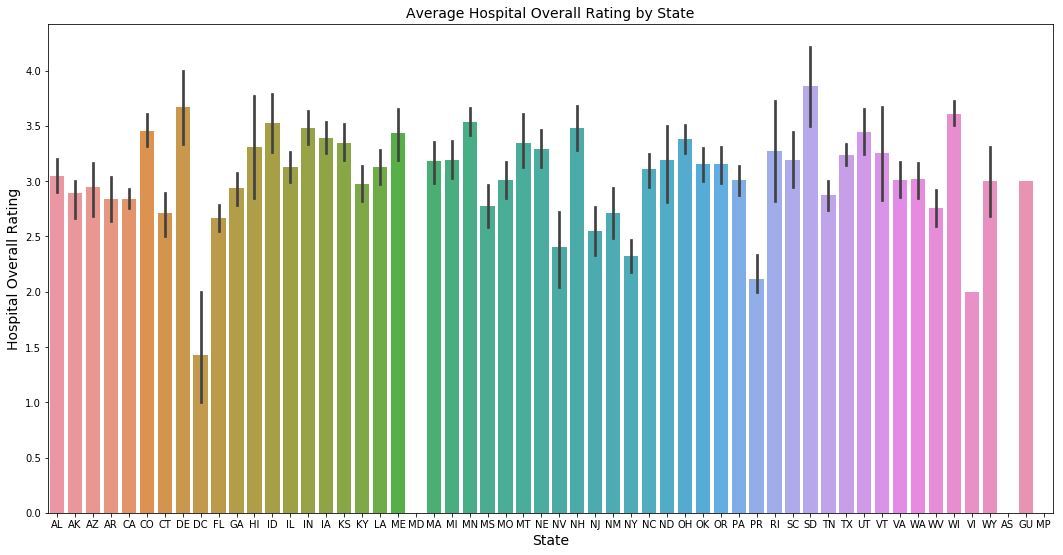

In [15]:
sb.barplot(x='state', y='hospital_overall_rating', data=hospitals)
plt.ylabel('Hospital Overall Rating',fontsize=14);
plt.xlabel('State', fontsize=14);
plt.title('Average Hospital Overall Rating by State', fontsize=14);

Next let's examine if the different types of ownership has anything to do with overall rating

In [16]:
hospitals.hospital_ownership.value_counts()

Voluntary non-profit - Private                 2057
Proprietary                                     804
Government - Hospital District or Authority     559
Voluntary non-profit - Other                    461
Government - Local                              404
Voluntary non-profit - Church                   338
Physician                                        67
Government - State                               66
Government - Federal                             47
Tribal                                            9
Name: hospital_ownership, dtype: int64

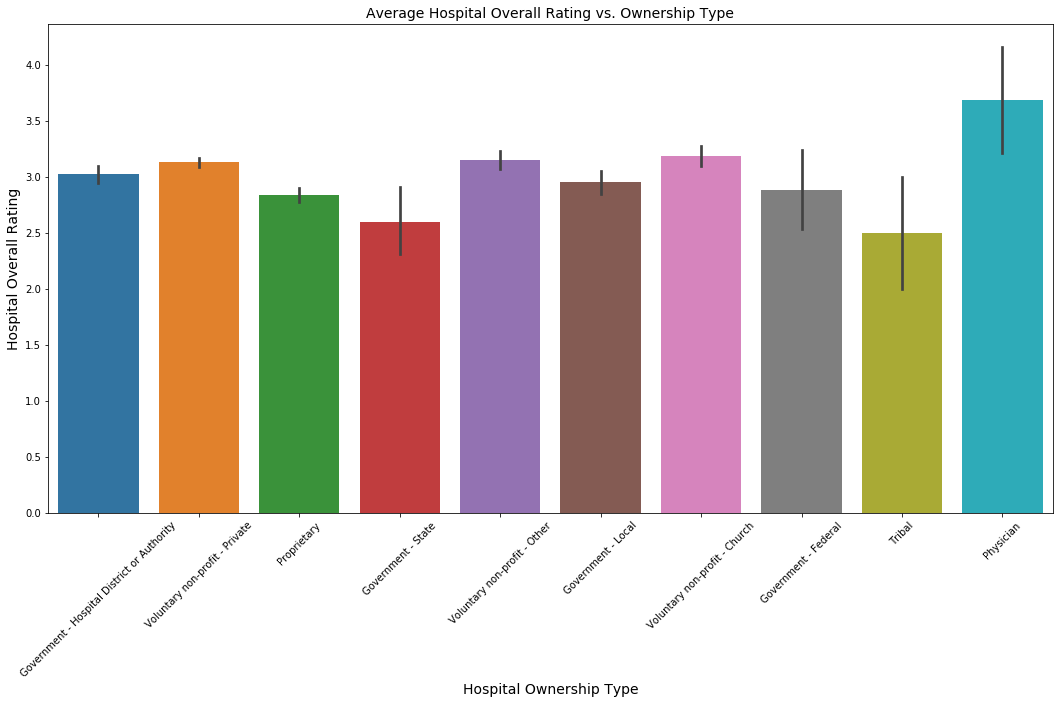

In [17]:
sb.barplot(x='hospital_ownership', y='hospital_overall_rating', data=hospitals)
plt.xticks(rotation=45);
plt.ylabel('Hospital Overall Rating',fontsize=14);
plt.xlabel('Hospital Ownership Type', fontsize=14);
plt.title('Average Hospital Overall Rating vs. Ownership Type', fontsize=14);

It appears that Hospitals that are directly owned by the Physicians have the highest overall rating, while hospitals that are owned by Tribal have the lowest

After briefly examining the Hospitals table, it appears that it is most useful to keep the following columns for the rest of our formal analysis:

- 'provider_id',
- 'hospital_name',
- 'city',
- 'state',
- 'zip_code',
- 'county_name',
- 'hospital_type',
- 'hospital_ownership',
- 'meets_criteria',
- 'hospital_overall_rating',
- 'mortality_national_compare',
- 'safety_of_care_national_comparison',
- 'readmission_national_comparison',
- 'patient_experience_national_comparison',
- 'effectiveness_of_care_national_comparison',
- 'timeliness_of_care_national_comparison'

We will keep the values of all ratings, score columns as strings for now given that we will do our aggregations in Pandas

#### We will next examine the Survey_Responses Table

The Survey Responses table gives more granular measurements about each hospital based on survey results. There are numerous columns that give results in the form "X out of 10" and we would like to glean information from this so we need to convert to numeric values

In [35]:
## Function to strip ' out of ' string from Series values 
def get_numeric_out_of(series):
    series = series.str.split(' out of ').str.get(0)
    return series

In [47]:
survey_responses[['communication_with_nurses_dimension_score',
                  'communication_with_doctors_dimension_score',
                  'responsiveness_of_hospital_staff_dimension_score',
                  'communication_about_medicines_dimension_score',
                  'cleanliness_and_quietness_of_hospital_environment_dimension_score', 
                  'discharge_information_dimension_score',
                  'overall_rating_of_hospital_dimension_score']] = survey_responses[['communication_with_nurses_dimension_score',
                  'communication_with_doctors_dimension_score',
                  'responsiveness_of_hospital_staff_dimension_score',
                  'communication_about_medicines_dimension_score',
                  'cleanliness_and_quietness_of_hospital_environment_dimension_score', 
                  'discharge_information_dimension_score',
                  'overall_rating_of_hospital_dimension_score']].apply(get_numeric_out_of)

### Effective Care

We notice that the effective_care table has two types of metrics for measure_ids. Using a measure_id of 'EDV' or Emergency Department Volumen, we notice that the scores are in volumetric measurements whereas the rest of the measure_ids are on a numeric scale for score

In [54]:
effective_care[effective_care['measure_id']=='EDV']['score'].value_counts()

Not Available                                 1362
Low (0 - 19,999 patients annually)            1211
Medium (20,000 - 39,999 patients annually)     961
Very High (60,000+ patients annually)          680
High (40,000 - 59,999 patients annually)       598
Name: score, dtype: int64

In [55]:
effective_care[effective_care['measure_id']!='EDV']['score'].value_counts()

Not Available    51501
100               4009
0                 3030
1                 1551
98                1485
99                1471
97                1262
2                 1148
96                1093
95                1029
94                 926
93                 842
3                  749
92                 736
91                 651
4                  637
90                 577
6                  550
5                  523
88                 505
8                  497
89                 477
7                  453
86                 435
85                 383
87                 382
82                 370
83                 350
10                 344
80                 333
                 ...  
572                  1
527                  1
544                  1
526                  1
384                  1
427                  1
538                  1
531                  1
533                  1
534                  1
535                  1
845                  1
417        

We will split the effective_care table by seperating out the scores that are pertaining to Emergency Department Volume from the rest of the scores

In [62]:
effective_care_regular = effective_care[effective_care['measure_id']!='EDV']
effective_care_vol = effective_care[effective_care['measure_id'] =='EDV'] 

In [65]:
effective_care_regular.loc[:, 'score'] = pd.to_numeric(effective_care_regular.loc[:, 'score']
                                                       .replace('Not Available', np.nan)) 

In [68]:
effective_care_regular.head()

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,condition,measure_id,measure_name,score,sample,footnote,measure_start_date,measure_end_date
0,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_1b,ED1,286.0,569,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
1,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_2b,ED2,99.0,569,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
3,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Preventive Care,IMM_2,Immunization for influenza,95.0,554,2 - Data submitted were based on a sample of c...,10/01/2015,03/31/2016
4,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Preventive Care,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,86.0,4457,,10/01/2016,03/31/2017
5,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,OP_1,Median Time to Fibrinolysis,NaN,Not Available,5 - Results are not available for this reporti...,01/01/2016,12/31/2016


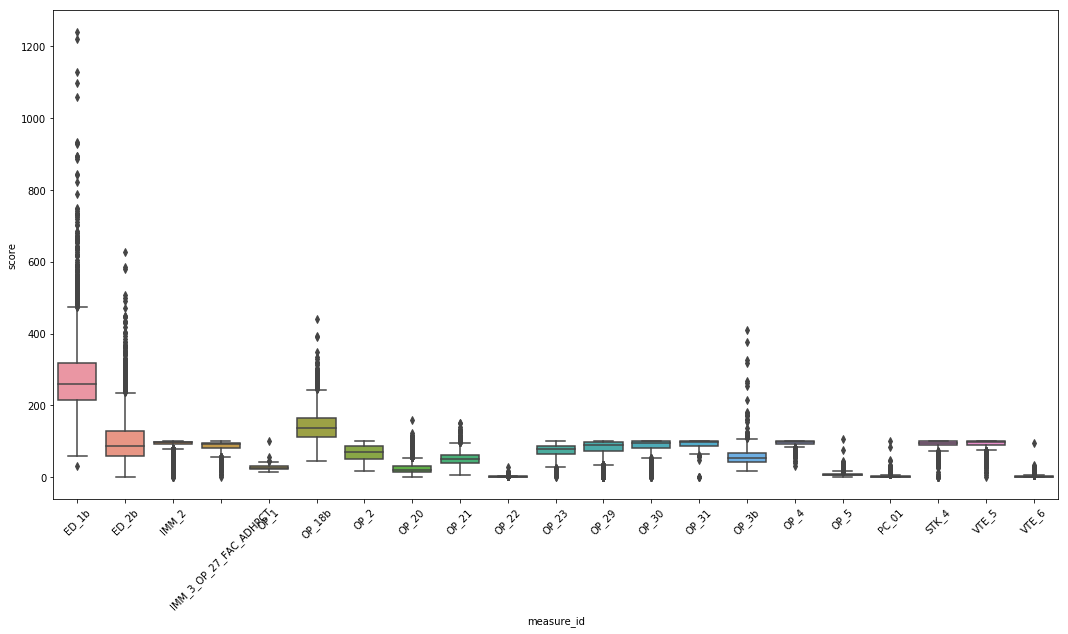

In [71]:
sb.boxplot(x = effective_care_regular['measure_id'], y = effective_care_regular['score'])
plt.xticks(rotation=45);

Out of the various measures at each hospital, we see that ED_1b has the highest variability. This measure_id stands for the "Average (median) time patients spent in the emergency department, before they were admitted to the hospital as an inpatient (alternate Measure ID: ED-1)"

Let's examine some hospitals with high scores on ED_1b

In [72]:
effective_care_regular[effective_care_regular['measure_id']=='ED_1b'].sort_values(by='score', ascending=False)

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,condition,measure_id,measure_name,score,sample,footnote,measure_start_date,measure_end_date
81158,400079,HOSP COMUNITARIO BUEN SAMARITANO,CARR.2 KM.1.4 AVE. SEVERIANO CUEVAS #18,AGUADILLA,PR,00603,AGUADILLA,7876580000,Emergency Department,ED_1b,ED1,1239.0,1052,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
81202,400098,HOSPITAL SAN FRANCISCO,371 DE DIEGO AVE,SAN JUAN,PR,00923,SAN JUAN,7877675100,Emergency Department,ED_1b,ED1,1221.0,552,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
81488,400117,HOSPITAL DR SUSONI INC,55 PALM ST,ARECIBO,PR,00614,ARECIBO,7876501031,Emergency Department,ED_1b,ED1,1129.0,237,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
80982,400019,HOSPITAL PAVIA SANTURCE,CALLE PROFESOR AUGUSTO RODRIGUEZ #1462,FERNANDEZ JUNCOS,PR,00910,SAN JUAN,7877276060,Emergency Department,ED_1b,ED1,1098.0,1592,,01/01/2016,12/31/2016
6512,050060,COMMUNITY REGIONAL MEDICAL CENTER,2823 FRESNO STREET,FRESNO,CA,93721,FRESNO,5594596000,Emergency Department,ED_1b,ED1,1059.0,683,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
10054,050492,CLOVIS COMMUNITY MEDICAL CENTER,2755 HERNDON AVE,CLOVIS,CA,93611,FRESNO,5593244000,Emergency Department,ED_1b,ED1,934.0,415,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
80894,400014,BELLA VISTA HOSPITAL,CARR 349 KM 2 7 CERRO LAS MESAS,MAYAGUEZ,PR,00681,MAYAGUEZ,7876526045,Emergency Department,ED_1b,ED1,930.0,775,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
81290,400105,HOSPITAL UNIVERSITARIO DR RUIZ ARNAU,LAUREL AVE SANTA JUANITA #100,BAYAMON,PR,00956,BAYAMON,7877875151,Emergency Department,ED_1b,ED1,927.0,628,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
8998,050315,KERN MEDICAL CENTER,1700 MOUNT VERNON AVENUE,BAKERSFIELD,CA,93306,KERN,6613262000,Emergency Department,ED_1b,ED1,895.0,475,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
81708,400128,"HOSPITAL PAVIA HATO REY, INC",AVE PONCE DE LEON 435,HATO REY,PR,00919,SAN JUAN,7877540909,Emergency Department,ED_1b,ED1,894.0,26,2 - Data submitted were based on a sample of c...,01/01/2016,12/31/2016
